<a href="https://colab.research.google.com/github/Voland24/ModernComputerVisionPytorch/blob/main/Chapter_5_Transfer_learning_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning

We know the model's performance increases with the number of images we have for training the model. However, it's not always possible to have the option of having thousands of labeled images, sometimes because there aren't enough images, sometimes because it's not possible to label them all with the ground truth labels. This is where transfer learning helps.

The idea here is to take the "learning" the model has done on some generic dataset with millions of examples and apply that to our case, finetuning the model to meet our demands.

Here, we will take a look at various iterations of two different architectures, VGG and ResNet.

We will understand the architectures, apply them to age and gender classification, learn to optimize over both cross entropy and mean absolute error losses at the same time, we will learn how to make the network output 136 values instead of just one and look at the library that can help us reduce code complexity.

Both the VGG and ResNet have been trained on the ImageNet dataset.

**Transfer learning use case scenario**

If we want to classify objects found on the images of streets, such as cars, trees etc. we would have a difficult time training a model from scratch since it's highly unlikely that we could account for all the variations the real world images could have in terms of objects, angles etc. It is much easier and better to use a pretrained model, that has seen countless images of our objects of interes, as well as other obejcts and use it to produce and emmbeding of the images and then just simply train a classificator to classify these images.

**Flow of transfer learning**

1. Normalize the input images with the same mean and stand dev as the images of the pretrained model
2. Fetch the pretrained model's weights and architecture
3. Discard the fully connected layer of the pretrained model
4. Connect our fully connected layer to the network and make sure it has enough output neurons as the classes we want to classify
5. Ensure the weights of the pretrained model are frozen since we don't want to train it any further
6. Update the weight of our layers over epochs




# VGG16 Architecture

VGG stands for Visual Geometry Group and 16 is the number of layers

In [3]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
!pip install torch_summary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load the VGG16 model and register it to the device

In [4]:
model = models.vgg16(pretrained = True).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Let's look at the model's architecture

In [5]:
summary(model, torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

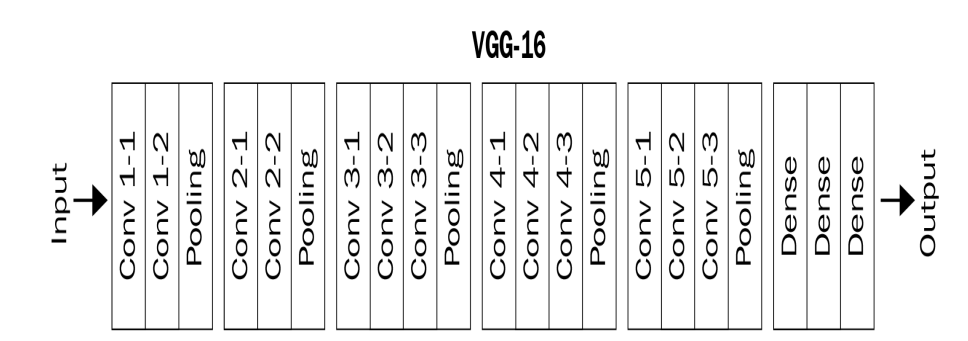

There are ~138 million parameters, of which ~122 million are at the end of the network, in the classification part. There are 13 convolutional layers and 3 linear layers.

In [6]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

There are three major sub modules in the model, the features, the avgpool and the clasiffier. The features and the avgpool modules would be frozen while we delete the classifier module. We delete it and then attach our classifier we wish to train with the desired number of outputs instead of 1000 for our classes we want to predict.


We will now use VGG16 network to classify images of dogs and cats, while training on a datasets that has only 500 images per class, 1000 images in total for class dog and for class cat.